In [ ]:
!pip install -q transformers peft bitsandbytes accelerate datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import notebook_login
notebook_login('HF_TOKEN')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:38: FutureWarning: Deprecated positional argument(s) used in 'notebook_login': pass new_session='HF_TOKEN' as keyword args. From version 1.0 passing these as positional arguments will result in an error,
  warnings.warn(


In [ ]:
import torch
import bitsandbytes as bnb
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, pipeline
from peft import LoraConfig, get_peft_model
from datasets import load_dataset

# Use a small model (Phi-2 or TinyLlama)
model_name = "microsoft/phi-2"  # Change to "TinyLlama/TinyLlama-1.1B-Chat-v1.0" for an even smaller model

In [ ]:
# Define model paths
base_model_name = "microsoft/phi-2"  # Change this to the original model you fine-tuned

#Base Model

# Load base (pre-trained) model & tokenizer
base_model = AutoModelForCausalLM.from_pretrained(base_model_name)
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)


# Setup text generation pipelines
base_text_generator = pipeline("text-generation", model=base_model, tokenizer=base_tokenizer)


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
prompt = "Tell me a story about a brave warrior."

# Generate from base model
base_output = base_text_generator(prompt, max_length=100, do_sample=True, temperature=0.7)[0]["generated_text"]


# Print results
print("\n🔷 **Base Model Output:**\n", base_output)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



🔷 **Base Model Output:**
 Tell me a story about a brave warrior.

Answer: Once upon a time, there was a brave warrior named László who lived in Hungary. He was known for his strength and courage in battle. One day, the king of Hungary sent him on a mission to defeat an enemy army that was threatening their kingdom. László and his army fought bravely, and they were able to defeat the enemy and save their kingdom. The king was so impressed with Lászl


In [ ]:
import math

def calculate_perplexity(model, tokenizer, text):
    encodings = tokenizer(text, return_tensors="pt")
    input_ids = encodings.input_ids.to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    perplexity = math.exp(loss.item())
    return perplexity


In [ ]:
# Compute perplexity for base model
base_ppl = calculate_perplexity(base_model, base_tokenizer, prompt)
print(f"\n Perplexity Score:")
print(f" Base Model Perplexity: {base_ppl:.4f}")


 Perplexity Score:
 Base Model Perplexity: 9.6085


In [ ]:
!pip install -q transformers peft bitsandbytes accelerate datasets
import torch
import bitsandbytes as bnb
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, pipeline
from peft import LoraConfig, get_peft_model
from datasets import load_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#fine tuning
model_name = "microsoft/phi-2"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model with 4-bit quantization for low VRAM usage
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    quantization_config={"load_in_4bit": True, "bnb_4bit_compute_dtype": torch.float16},
)

# Apply LoRA to reduce trainable parameters
lora_config = LoraConfig(
    r=4, lora_alpha=8, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

# Load dataset (Alpaca dataset)
dataset = load_dataset("tatsu-lab/alpaca")

# Tokenize dataset and add labels for loss computation


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

(…)-00000-of-00001-a09b74b3ef9c3b56.parquet:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [ ]:
def tokenize_function(examples):
    inputs = tokenizer(
        [instr + "\n" + output for instr, output in zip(examples["instruction"], examples["output"])],
        truncation=True, padding="max_length", max_length=128
    )
    inputs["labels"] = inputs["input_ids"].copy()
    return inputs
# Assign a padding token if the tokenizer doesn't have one
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as padding


tokenized_datasets = dataset.map(tokenize_function, batched=True)


# Training arguments optimized for speed
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    weight_decay=0.01,
    fp16=True,
    num_train_epochs=1,
    logging_steps=10,
    report_to="none",
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].select(range(5000)),  # Use a small subset for fast training
    eval_dataset=tokenized_datasets["train"].select(range(500)),  # Quick evaluation
)

# Fine-tune the model (under 15 min)
trainer.train()

# Save trained model
trainer.save_model("./fine_tuned_phi2")
tokenizer.save_pretrained("./fine_tuned_phi2")

print("Fine-tuning complete! Model saved at './fine_tuned_phi2'.")


Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,0.624200,0.562165


Fine-tuning complete! Model saved at './fine_tuned_phi2'.


In [ ]:
import shutil

# Define model save path
model_path = "./fine_tuned_phi2"

# Zip the model directory
shutil.make_archive("fine_tuned_phi2", 'zip', model_path)

print("✅ Model zipped successfully!")
from google.colab import files

# Download the zipped model
files.download("fine_tuned_phi2.zip")


✅ Model zipped successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load the fine-tuned model and tokenizer
model_path = "./fine_tuned_phi2"  # Ensure this is the correct path
model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Setup text generation pipeline
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
prompt = "Tell me a story about a brave warrior."

fine_tuned_output = text_generator(prompt, max_length=100, do_sample=True, temperature=0.7)[0]["generated_text"]
print("\n🔶 **Fine-Tuned Model Output:**\n", fine_tuned_output)


🔶 **Fine-Tuned Model Output:**
 Tell me a story about a brave warrior.
The brave warrior had a heart of gold and a spirit of courage. He had honed his skills through years of training and practice. He was fearless and would never back down from a challenge, no matter how difficult it seemed. He had a special bond with his allies, who were like family to him. He faced many foes in his lifetime, but always emerged victorious. He was known far and wide for his bravery and courage, and was a


In [ ]:
base_output = "Tell me a story about a brave warrior.\nInput: \nOutput: Once upon a time, there was a brave warrior named Kael. He was known throughout the kingdom for his strength, courage, and unwavering loyalty. Kael was a skilled swordsman and a master strategist, always ready to defend his people from any threat.\nOne day, a dark and powerful enemy invaded the kingdom. The enemy was a fearsome army of dragons, and they had already conquered many cities and"

In [ ]:
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

# Load embedding model (small and efficient)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Get embeddings
base_embedding = embedding_model.encode(base_output, convert_to_tensor=True)
fine_tuned_embedding = embedding_model.encode(fine_tuned_output, convert_to_tensor=True)

# Compute cosine similarity
similarity_score = F.cosine_similarity(base_embedding, fine_tuned_embedding, dim=0)

print(f"\n📊 Cosine Similarity Between Outputs: {similarity_score.item():.4f} (higher = more similar)")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


📊 Cosine Similarity Between Outputs: 0.7960 (higher = more similar)


In [ ]:
import math

def calculate_perplexity(model, tokenizer, text):
    encodings = tokenizer(text, return_tensors="pt")
    input_ids = encodings.input_ids.to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    perplexity = math.exp(loss.item())
    return perplexity

In [ ]:
# Example prompt
prompt = "Tell me a story about a brave warrior."

# Compute perplexity for base model
# Compute perplexity for fine-tuned model
fine_tuned_ppl = calculate_perplexity(model,tokenizer, prompt)

print(f"Perplexity Scores:")
print(f" Fine-Tuned Model Perplexity: {fine_tuned_ppl:.4f}")

Perplexity Scores:
 Fine-Tuned Model Perplexity: 3.9763


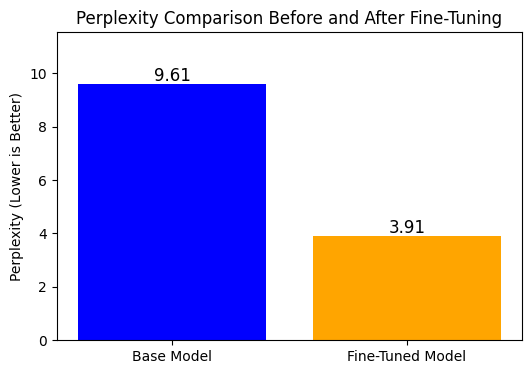

In [ ]:
fine_tuned_ppl= 3.9057
base_ppl= 9.6085
import matplotlib.pyplot as plt

# Data for visualization
models = ["Base Model", "Fine-Tuned Model"]
perplexities = [base_ppl, fine_tuned_ppl]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(models, perplexities, color=['blue', 'orange'])
plt.ylabel("Perplexity (Lower is Better)")
plt.title("Perplexity Comparison Before and After Fine-Tuning")
plt.ylim(0, max(perplexities) * 1.2)  # Adjust y-axis for clarity

# Annotate values
for i, val in enumerate(perplexities):
    plt.text(i, val + 0.1, f"{val:.2f}", ha='center', fontsize=12)

plt.show()
